<a href="https://colab.research.google.com/github/asiyabb/Emotion-Detection-FER2013/blob/main/01_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FER2013 — Data preparation & EDA
This Colab-ready notebook covers: setup, optional Drive mount, optional Kaggle download, CSV parsing (if using CSV), preprocessing, augmentation and basic EDA. Run cells in order.

In [1]:
# Check GPU availability (Colab: ensure Runtime -> Change runtime type -> GPU)
import tensorflow as tf
print('TF version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))

TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Install required packages (Colab)
!pip install -q tensorflow==2.12.0 tensorflow-addons matplotlib scikit-learn opencv-python-headless keras-tuner albumentations pandas

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


In [3]:
# Optional: mount Google Drive (uncomment if using Drive)
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/FER2013'

Mounted at /content/drive


In [4]:
# Choose dataset mode: 'folders' if you uploaded folder with subfolders per class, or 'csv' to parse fer2013.csv
DATA_MODE = 'folders'  # 'folders' or 'csv'
# Set DATA_DIR to your dataset path (update if using Drive)
DATA_DIR = '/content/drive/MyDrive/FER2013'
print('DATA_MODE=', DATA_MODE, 'DATA_DIR=', DATA_DIR)

DATA_MODE= folders DATA_DIR= /content/drive/MyDrive/FER2013


In [5]:
import os, numpy as np, pandas as pd
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
BATCH_SIZE = 32
IMG_SIZE = (48,48)

In [6]:
if DATA_MODE == 'folders':
    train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR, validation_split=0.2, subset='training', seed=123, image_size=IMG_SIZE, color_mode='grayscale', batch_size=BATCH_SIZE)
    val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR, validation_split=0.2, subset='validation', seed=123, image_size=IMG_SIZE, color_mode='grayscale', batch_size=BATCH_SIZE)
    class_names = train_ds.class_names
else:
    # Parse fer2013.csv (expected columns: emotion, pixels, usage)
    df = pd.read_csv(os.path.join(DATA_DIR, 'fer2013.csv'))
    # Convert pixel strings to numpy arrays and create folders in /content/FER2013_by_folder for image_dataset_from_directory
    out_dir = Path('/content/FER2013_by_folder')
    out_dir.mkdir(exist_ok=True)
    label_map = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}
    from PIL import Image
    def save_from_row(idx,row):
        lab = label_map[int(row['emotion'])]
        lab_dir = out_dir/lab
        lab_dir.mkdir(exist_ok=True, parents=True)
        pixels = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8)
        img = pixels.reshape(48,48)
        Image.fromarray(img).save(lab_dir/f'{idx}.png')
    # iterate and save (may take a few minutes)
    for i, r in df.iterrows():
        save_from_row(i,r)
    train_ds = tf.keras.utils.image_dataset_from_directory(str(out_dir), validation_split=0.2, subset='training', seed=123, image_size=IMG_SIZE, color_mode='grayscale', batch_size=BATCH_SIZE)
    val_ds = tf.keras.utils.image_dataset_from_directory(str(out_dir), validation_split=0.2, subset='validation', seed=123, image_size=IMG_SIZE, color_mode='grayscale', batch_size=BATCH_SIZE)
    class_names = train_ds.class_names
print('Classes:', class_names)

Found 35888 files belonging to 2 classes.
Using 28711 files for training.
Found 35888 files belonging to 2 classes.
Using 7177 files for validation.
Classes: ['test', 'train']


In [7]:
# Preprocessing: convert grayscale->RGB and resize to 96x96 for transfer models, normalize, and prefetch
AUTOTUNE = tf.data.AUTOTUNE
def prepare_ds(ds, shuffle=False):
    ds = ds.map(lambda x,y: (tf.image.resize(tf.image.grayscale_to_rgb(x), (96,96)), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.prefetch(AUTOTUNE)
train_ds = prepare_ds(train_ds, shuffle=True)
val_ds = prepare_ds(val_ds)
print('Prepared train and val datasets')

Prepared train and val datasets


In [8]:
# Augmentation examples
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.12),
    tf.keras.layers.RandomZoom(0.08),
])
# Albumentations example (applied per-Numpy image, slower in tf.data without wrappers)
import albumentations as A
alb_aug = A.Compose([A.HorizontalFlip(), A.RandomBrightnessContrast(), A.ShiftScaleRotate(rotate_limit=15)])
print('Augmentations ready')

Augmentations ready


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


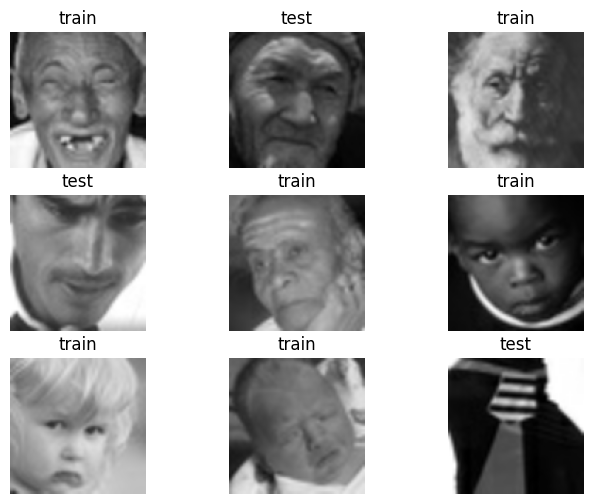

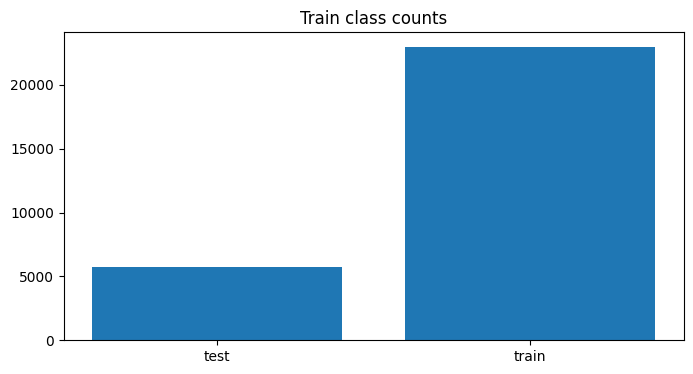

In [9]:
# Visualize samples and class distribution
import numpy as np, matplotlib.pyplot as plt
def show_batch(ds, class_names, n=9):
    for images, labels in ds.take(1):
        plt.figure(figsize=(8,6))
        for i in range(n):
            ax = plt.subplot(3,3,i+1)
            img = images[i].numpy()
            plt.imshow(img)
            plt.title(class_names[int(labels[i])])
            plt.axis('off')
        plt.show()
show_batch(train_ds, class_names)
# Class distribution
counts = {c:0 for c in class_names}
for _, labels in train_ds.unbatch():
    lab = labels.numpy() if hasattr(labels, 'numpy') else int(labels)
    counts[class_names[int(lab)]] += 1
plt.figure(figsize=(8,4)); plt.bar(counts.keys(), counts.values()); plt.title('Train class counts'); plt.show()

Next: open `02_train_transfer_learning.ipynb` to train baseline and transfer-learning models.